# Implementation of a flow through a tube
Javier E. Santos


Description: This notebook calculates the steady-state single-phase laminar flow and the permeability of tube

In [1]:
cd ..

/Users/jesantos/src/lettuce


In [8]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import lettuce as lt

## Define Flow and Boundary Condition

In [9]:
class PeriodicPressureBC:
    """According to Ehsan Evati: 'High performance simulation of fluid flow in porous media...' 
    """
    def __init__(self, lattice, delta_rho):
        self.lattice   = lattice
        self.delta_rho = delta_rho
        
    def __call__(self, f):
        f[[1,5,8], 0,:] = f[[1,5,8], 0,:] + self.lattice.w[[1,5,8],None] * self.delta_rho
        f[[3,6,7],-1,:] = f[[3,6,7],-1,:] - self.lattice.w[[3,6,7],None] * self.delta_rho
        return f

In [10]:
class PorousMedium2D(lt.Obstacle2D):
    def __init__(
            self,
            pressure_difference, 
            resolution_x,
            resolution_y,
            reynolds_number,
            mach_number,
            lattice,
            char_length_lu
    ):
        super().__init__(
            resolution_x,
            resolution_y,
            reynolds_number,
            mach_number,
            lattice,
            char_length_lu
        )
        self.delta_rho = pressure_difference
    
    #@property
    #def delta_rho(self):
    #    rho_in = self.units.convert_pressure_pu_to_density_lu(self.pressure_difference/2)
    #    rho_out = self.units.convert_pressure_pu_to_density_lu(-self.pressure_difference/2)
    #    return rho_in - rho_out
    
    @property
    def boundaries(self):
        return [
            # left/right
            PeriodicPressureBC(self.units.lattice, self.delta_rho),
            # bounce back periodic medium
            lt.BounceBackBoundary(self.mask, self.units.lattice)
            # periodic in y direction
        ]

## Setting up domain and flow parameters

In [21]:
# user-defined parameters

nx = 500 # domain length in x-dir
ny = 500 # domain length in y-dir

n_buffer = 10 # number of buffer layers
it_check = 1000 # check for convergence every n-iterations 
it_max   = 1e7 # break after max its its reached
epsilon  = 0.01 # break after the diff between its it's less than e %

delta_rho_lu = 0.05 # my code uses 0.0005
resolution   = 1e-6 # [lu/pu] microns

device = device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
dtype  = torch.float64 # torch types: torch.float64 is stable and accurate

In [22]:
lattice = lt.Lattice(lt.D2Q9, device, dtype)

In [23]:
Ma    = 0.01 # I set this arbitrarily
u_lbm = lattice.cs*Ma

omega = 1.0
nu    = (1/omega - 0.5)/(1/lattice.cs)**2
Re    = u_lbm*nx/nu


flow = PorousMedium2D(
    delta_rho_lu, ny, nx, reynolds_number=Re, mach_number=Ma, 
    lattice=lattice, char_length_lu=nx
)

In [24]:
# make a tube
flow.mask[ :, :] = 1
flow.mask[ :, ny//2-10:ny//2+10] = 0
    
# make a buffer region that should have constant pressure
flow.mask[ :n_buffer, :] = 0
flow.mask[-n_buffer:, :] = 0

# calculate porosity
phi = 1-np.sum(flow.mask)/(nx*ny)

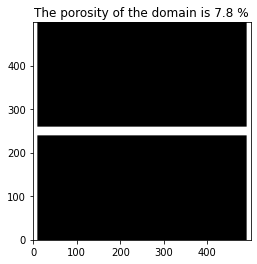

In [25]:
plt.imshow(flow.mask.transpose(), origin="lower", cmap='gray_r')
plt.title(f'The porosity of the domain is {phi*100:2.1f} %');

## Run Simulation

In [26]:
collision  = lt.BGKCollision(lattice, tau=flow.units.relaxation_parameter_lu)
streaming  = lt.StandardStreaming(lattice)
simulation = lt.Simulation(lattice=lattice, flow=flow, streaming=streaming, collision=collision)

In [27]:
u_t = [np.Inf] # save it info for plotting
for i in range(1,int(it_max//it_check)):   
    simulation.step(it_check)
    u_t.append(lattice.u(simulation.f).mean()) 
    rel_change = ((u_t[-1]-u_t[-2])/u_t[-1]*100).abs() 
    print(f'it {i*it_check} {u_t[-1]} the relative change in mean vel is {rel_change} %')
    if rel_change < epsilon:
        break

it 1000 0.00013143229952937012 the relative change in mean vel is inf %
it 2000 0.00012777663190523866 the relative change in mean vel is 2.8609829274906637 %
it 3000 0.00012779288972437347 the relative change in mean vel is 0.012722006028563347 %
it 4000 0.00012779576186013427 the relative change in mean vel is 0.0022474421052768373 %


Text(0, 0.5, 'mean log10(|velocity|) [lus]')

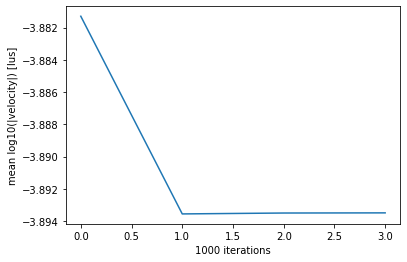

In [28]:
u_t = [x.cpu().numpy() for x in u_t[1:]]
plt.plot(np.log10(np.abs(u_t)))
plt.xlabel(f'{it_check} iterations')
plt.ylabel(f'mean log10(|velocity|) [lus]')

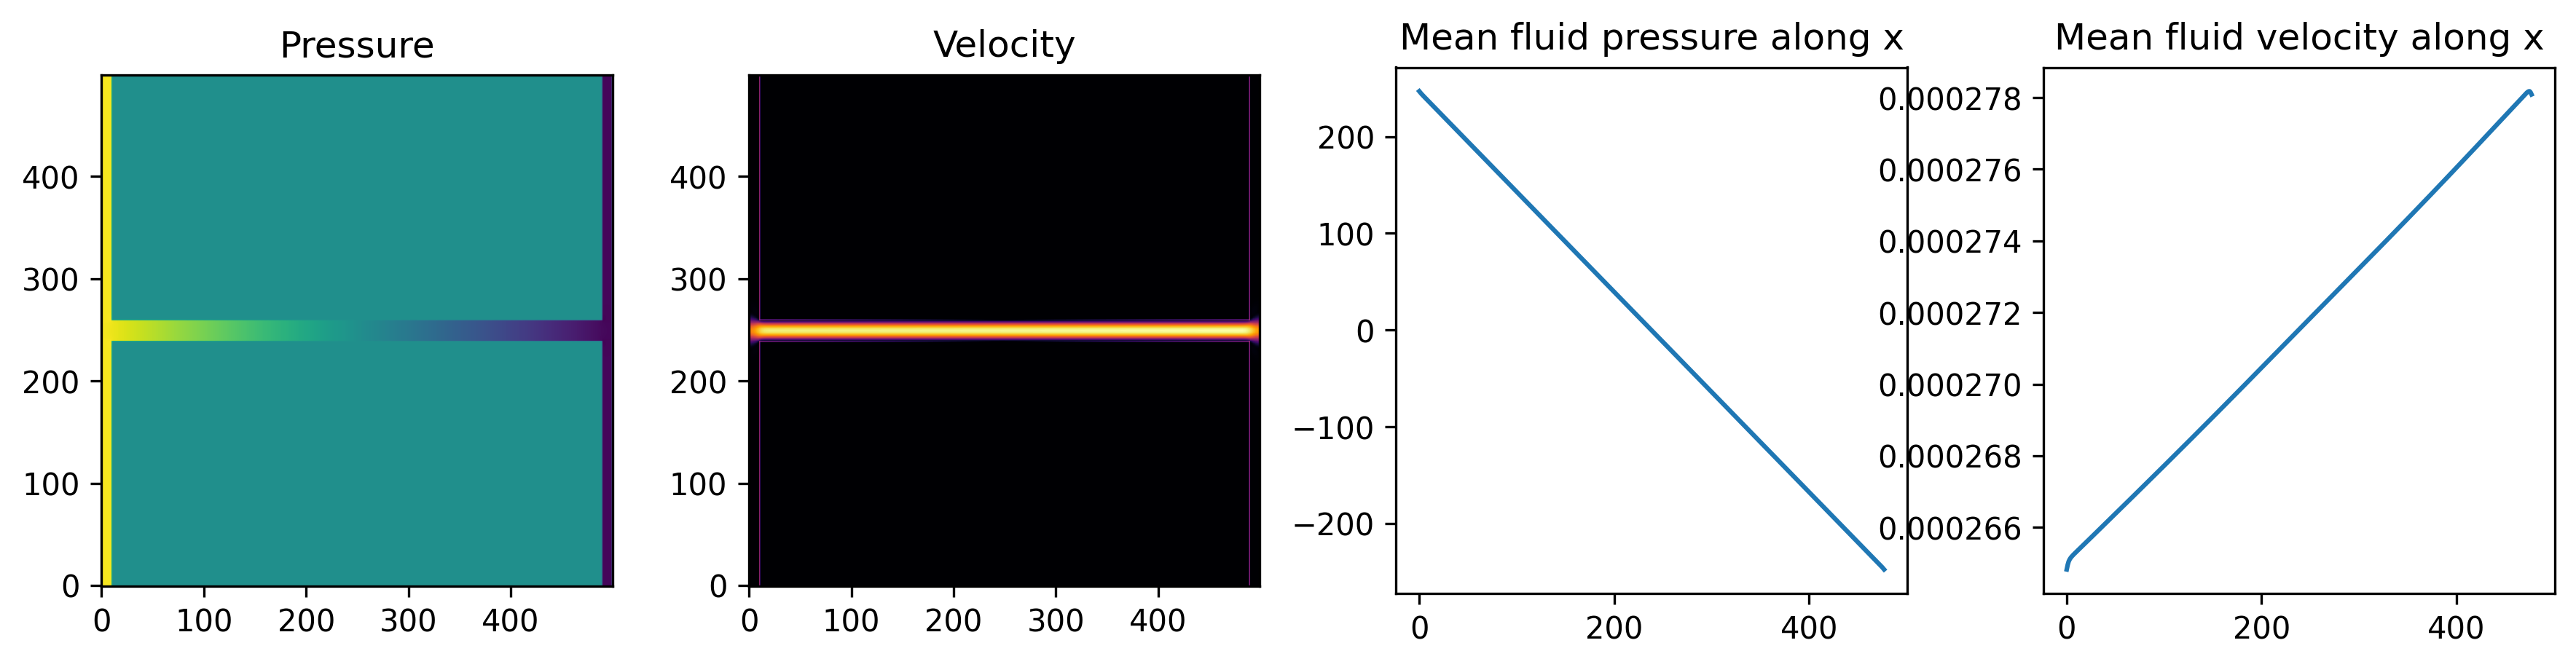

In [36]:
u = lattice.u(simulation.f)
k = nu*u.mean()/(delta_rho_lu/nx)*resolution**2
rho = lattice.rho(simulation.f)
u = u.cpu().detach().numpy()
p = flow.units.convert_density_lu_to_pressure_pu(rho).cpu().detach().numpy()
unorm = np.linalg.norm(u, axis=0)

# Plot without outliers due to bounce-back contacts
fig, axes = plt.subplots(1,4, figsize=(12,3), dpi=300)
fig.tight_layout()
axes[0].set_title("Pressure")
axes[0].imshow(p[0].transpose(), origin="lower", )#vmin=p[0,ny-1,0], vmax=p[0].mean(axis=-1).max())
axes[1].set_title("Velocity")
axes[1].imshow(unorm.transpose(), origin="lower", cmap='inferno',
               #vmin=np.percentile(unorm.flatten(),1),
               #vmax=np.percentile(unorm.flatten(),95)
              )
axes[2].set_title("Mean fluid pressure along x")
axes[2].plot((p[0].sum(axis=-1)/(np.logical_not(flow.mask).sum(axis=-1)))[n_buffer+1:-n_buffer-1])
axes[3].set_title("Mean fluid velocity along x")
axes[3].plot(u[0].mean(axis=1)[n_buffer+1:-n_buffer-1]);

#                                                                                               This is weird :(

In [357]:
(.000266-.000278)/.000266*100

-4.511278195488709

In [37]:
print(f'Porosity = {phi*100} % and Permeability = {k} [m^2]')

Porosity = 7.8400000000000025 % and Permeability = 2.129929364335572e-13 [m^2]
